In [4]:
# Imports 
import os
import matplotlib.pyplot as plt
from array import array
from ROOT import TFile, TTree
import numpy as np

In [49]:
def save_names(split_names):
    for i in range(0, len(split_names), 3):
        name_list.append(split_names[i])
        min_list.append(split_names[i+1])
        max_list.append(split_names[i+2])
        
def get_sorted_plots(plots):
    
    

    # Create a new dict to store the sorted plots
    sorted_plots = []
    
    for plot in plots:
        sorted_plot={}
        # Get the sorted index of centers
        sorted_index = np.argsort(plot['centers'])
        # Iterate through the keys in plots
        for key in plot.keys():
            if key == 'name':
                sorted_plot['name']=plot[key]
                continue
            sorted_plot[key]=plot[key][sorted_index]
        sorted_plots.append(sorted_plot)
    
    return sorted_plots

def get_modulations(L):
    char_vec = []
    str_vec = []
    for l in range(0, L+1):
        for m in range(1, l+1):
            if(m==1):
                string = "\sin(" + "\phi_{h}-" + "\phi_{R})"
            else:
                string = "\sin(" + str(m) +"\phi_{h}-" + str(m) +"\phi_{R})"
            str_vec.append(string)
        for m in range(-l, l+1):
            if(m==1):
                string = "\sin("+"\phi_{R})"
            elif(m==2):
                string = "\sin("  + "-\phi_{h}+" + str(m) +"\phi_{R})"
            elif(m==0):
                string = "\sin("+"\phi_{h})"
            elif(m==-1):
                string = "\sin(" + str(1-m) + "\phi_{h}-" + "\phi_{R})"
            elif(m<0):
                string = "\sin(" + str(1-m) + "\phi_{h}" + str(m) +"\phi_{R})"
            else:
                string = "\sin(" + str(1-m) + "\phi_{h}+" + str(m) +"\phi_{R})"
            str_vec.append(string)
    # Remove duplicate entries
    str_vec.sort()
    str_vec = list(dict.fromkeys(str_vec))
    cidx = 0
    for c in range(ord('A'), ord('A')+len(str_vec)):
        string = ""
        string += chr(c)
        char_vec.append(string)
        cidx += 1
    return (char_vec, str_vec)

In [50]:
# Initializing lists 
name_list = []
min_list = []
max_list = []
nll_list = []

yld_azi_list = []
yld_azi_err_list = []

param_list = []
err_list = []
param_name_list = []
err_name_list = []
# Change directory
os.chdir("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/catboost/binned_pipluspi0/test1d")

# Outer loop
for subdir in os.listdir("bru_obs"):
    # Split the subdirectory name
    split_names = subdir.split("_")

    # Open the TFile
    f = TFile(f"bru_obs/{subdir}/ResultsHSMinuit2.root")
    # Open the TTree
    t = f.Get("ResultTree")
    t.GetEntry(0)
    # Get the TBranches
    nll = t.GetBranch("NLL")
    yld_azi = t.GetBranch("Yld_AziFit")
    yld_azi_err = t.GetBranch("Yld_AziFit_err")
    
    # Get the remaining TBranch names
    branches = []
    for i in range(0, t.GetListOfBranches().GetEntries()-3):
        branches.append(t.GetListOfBranches().At(i).GetName())
    
    # Get the entries from the TBranch
    nll_list.append(nll.GetEntry(0))
    yld_azi_list.append(yld_azi.GetEntry(0))
    yld_azi_err_list.append(yld_azi_err.GetEntry(0))
    
    for branch in branches:
        if branch.endswith("err"):
            exec("err_list.append(t.{})".format(branch))
            err_name_list.append(branch)
            save_names(split_names)
        else:
            exec("param_list.append(t.{})".format(branch))
            param_name_list.append(branch)
        

# Comparing each "A", "B", etc. list
plots=[]
for name in np.unique(name_list):
    plotdict={}
    plotdict["name"]=name
    BOOL =  [True if n == name else False for n in name_list]
    parNames = np.array(param_name_list)[BOOL]
    errNames = np.array(err_name_list)[BOOL]
    par = np.array(param_list)[BOOL]
    err = np.array(err_list)[BOOL]
    center = 0.5*(np.array(min_list,dtype=float)[BOOL]+np.array(max_list,dtype=float)[BOOL])
    for p in parNames:
        BOOL =  [True if n == p else False for n in parNames]
        center2 = center[BOOL]
        plotdict["centers"]=center2
        par2  = par[BOOL]
        
        plotdict[p]=par2
        
    for e in errNames:
        BBOOL =  [True if n == e else False for n in errNames]
        err2 = err[BOOL]
        
        plotdict[e]=err2
        
    plots.append(plotdict)

# Sort by center
plots=get_sorted_plots(plots)

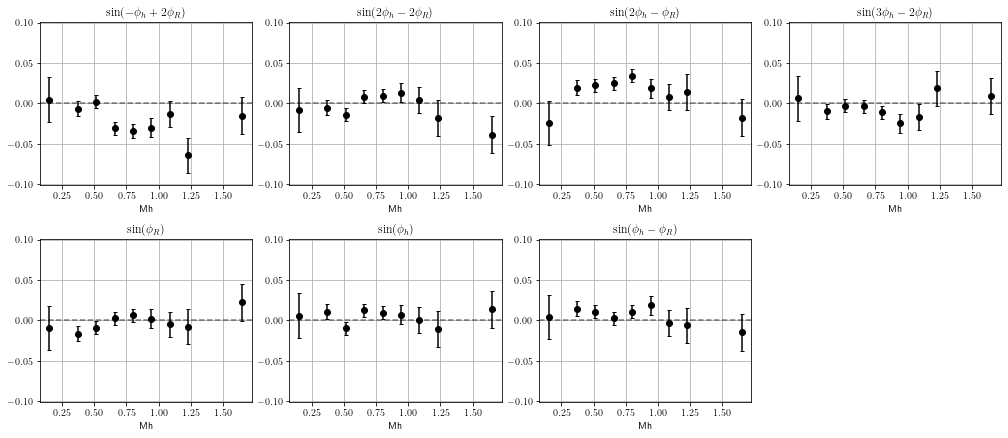

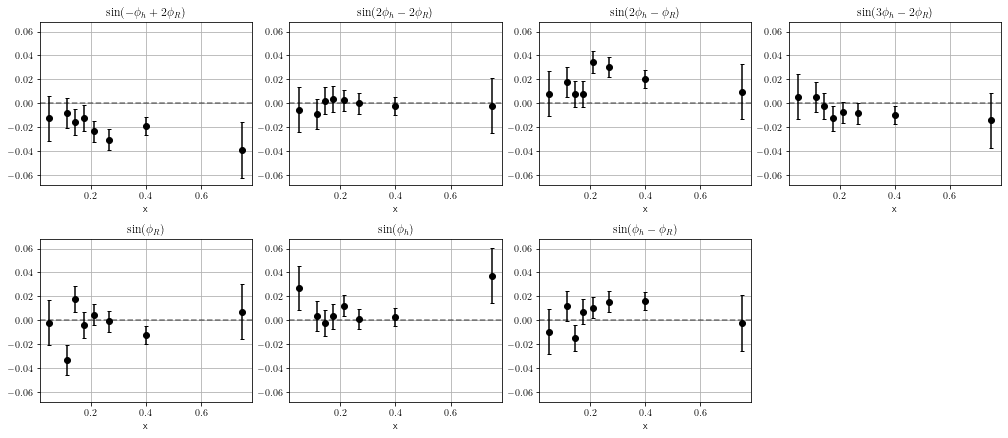

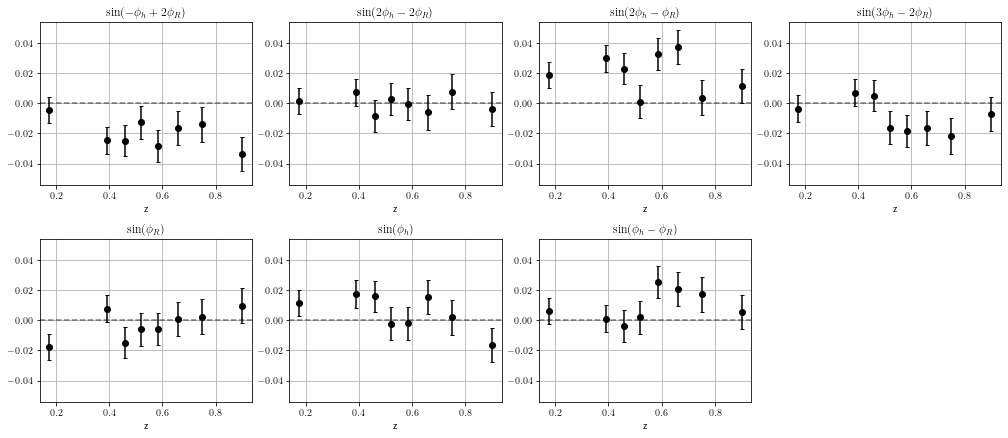

In [51]:

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

for plot in plots:
    nPlots = len(plot.keys())-2
    variables = [key for key in plot.keys() if not (key.endswith('_err') or key=="name" or key=="centers")]
    mods = get_modulations(2)[1]
    rows = (len(variables) // 4) + 1
    fig, axes = plt.subplots(rows, 4, figsize=(14, 3 * rows))
    
    yvals = [y for var in variables for y in plot[var] ]
    yerrs = [y for var in variables for y in plot[var+"_err"] ]
    ymax = (np.amax(np.abs(yvals))+np.amax(np.abs(yerrs)))*1.1
    for var,mod,ax in zip(variables,mods,axes.flatten()):
        x = plot['centers']
        y = plot[var]
        yerr = plot[var + '_err']
        ax.errorbar(x, y, yerr=yerr,fmt="ko",capsize=2)
        ax.set_xlabel(plot['name'])
        ax.set_ylim(-ymax,ymax)
        ax.grid()
        ax.axhline(0, ls='--', color='black',alpha=0.5)
        ax.set_title(r'${}$'.format(mod))
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    while(nPlots/2 < len(axes.flatten())):
        fig.delaxes(axes.flatten()[-1])
        nPlots+=2
    